<a href="https://colab.research.google.com/github/PolianaQueiroz/Master-Research-Lab/blob/main/goldman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("\n✅ Google Drive montado.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Google Drive montado.


In [ ]:
# Instala pmdarima para seleção automática de parâmetros ARIMA
!pip install pmdarima

# Instala prophet (requer pystan, por isso a instalação em duas etapas).
!pip install pystan~=2.19.1.1
!pip install prophet

print("\n✅ Bibliotecas instaladas com sucesso.")

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pystan
  Running setup.py clean for pystan
Failed to build pystan
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pystan)

✅ Bibliotecas instaladas com sucesso.


In [ ]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import pmdarima as pm
from prophet import Prophet
from sklearn.metrics import mean_squared_error

In [ ]:
# Configuração de visualização
plt.style.use('ggplot')
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
FILE_NAME = "/content/drive/MyDrive/Trabalho de PPE/goldman.xlsx"

try:
    # Tentativa de ler como CSV, pois o Colab pode tratar arquivos XLSX com apenas uma coluna como CSV
    df = pd.read_csv(FILE_NAME, header=None, names=['Price'])
    print("✅ Arquivo lido como CSV (Conteúdo: uma coluna de preços).")
except Exception:
    # Se falhar como CSV, tenta ler como o formato .xlsx que consta no caminho
    try:
        df = pd.read_excel(FILE_NAME, header=None, names=['Price'])
        print("✅ Arquivo lido como XLSX (Conteúdo: uma coluna de preços).")
    except Exception as e:
        print(f"⚠️ ERRO CRÍTICO AO LER ARQUIVO. Verifique o caminho e o formato: {e}")
        # Aborta a execução se não conseguir ler
        raise

# Cria um índice de data. Assumimos que cada linha representa um dia útil consecutivo ('B')
num_days = len(df)
start_date = '2020-01-01'
date_range = pd.date_range(start=start_date, periods=num_days, freq='B')
df.index = date_range

print("\n✅ Dados Carregados e Indexados. Primeiras 5 linhas:")
print(df.head())

# Define o ponto de corte para treino e teste (Ex: 80% treino, 20% teste)
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

✅ Arquivo lido como XLSX (Conteúdo: uma coluna de preços).

✅ Dados Carregados e Indexados. Primeiras 5 linhas:
            Price
2020-01-01 165.09
2020-01-02 168.01
2020-01-03 166.22
2020-01-06 169.47
2020-01-07 166.27


In [ ]:
print("\n🛠️ Treinando Modelo ARIMA...")

# Utiliza auto_arima para encontrar a melhor combinação de (p, d, q)
arima_model = pm.auto_arima(train['Price'],
                            start_p=1, start_q=1,
                            max_p=3, max_q=3,
                            m=1, # Sazonalidade (m=1 para dados não sazonais)
                            d=None, # Permite que o auto_arima encontre o d (ordem de diferenciação)
                            seasonal=False,
                            start_P=0,
                            D=0,
                            trace=True, # Mostra os modelos testados
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(f"\n✅ Melhor Parâmetro ARIMA (p, d, q): {arima_model.order}")

# Faz a previsão
forecast_periods = len(test)
arima_forecast = arima_model.predict(n_periods=forecast_periods)
arima_forecast_series = pd.Series(arima_forecast, index=test.index)

# Calcula o erro
arima_rmse = np.sqrt(mean_squared_error(test['Price'], arima_forecast_series))
print(f"📊 RMSE (Raiz do Erro Quadrático Médio) do ARIMA: {arima_rmse:,.2f}")


🛠️ Treinando Modelo ARIMA...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2903.617, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2912.530, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2907.150, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2907.448, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2911.616, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2904.046, Time=0.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2903.939, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2909.147, Time=0.49 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2908.941, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2905.748, Time=1.87 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2902.795, Time=0.72 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2906.834, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2906.516, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2903.351, Time=0.75 sec
 AR

In [ ]:
# 4. MODELO 2: PROPHET
# --------------------------------------------------------------------------
print("\n🛠️ Treinando Modelo Prophet...")

# O Prophet requer colunas específicas: 'ds' (data) e 'y' (valor)
prophet_df = df.reset_index().rename(columns={'index': 'ds', 'Price': 'y'})
prophet_train = prophet_df[:train_size]
prophet_test = prophet_df[train_size:]

# Configura e treina o modelo Prophet
m = Prophet(seasonality_mode='multiplicative',
            daily_seasonality=False)
m.fit(prophet_train)

# Cria um DataFrame para as futuras datas (período de teste)
future = m.make_future_dataframe(periods=forecast_periods, freq='B') # 'B' para dias úteis

# Faz a previsão
prophet_forecast = m.predict(future)

# Filtra a previsão para o período de teste e alinha com o teste real
prophet_forecast_series = prophet_forecast.set_index('ds').loc[prophet_test['ds']]['yhat']

# Calcula o erro
prophet_rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_forecast_series))
print(f"📊 RMSE (Raiz do Erro Quadrático Médio) do Prophet: {prophet_rmse:,.2f}")


🛠️ Treinando Modelo Prophet...
📊 RMSE (Raiz do Erro Quadrático Médio) do Prophet: 42.42


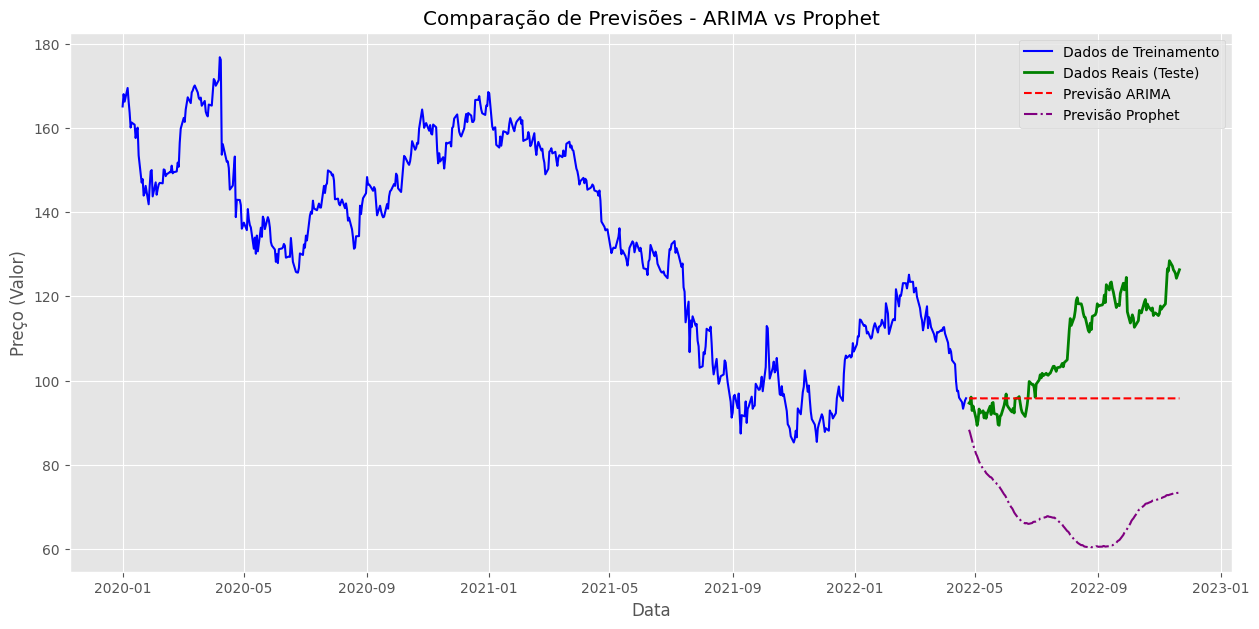

In [ ]:
# 5. VISUALIZAÇÃO DOS RESULTADOS
# --------------------------------------------------------------------------
plt.figure(figsize=(15, 7))
plt.title('Comparação de Previsões - ARIMA vs Prophet')
plt.plot(train.index, train['Price'], label='Dados de Treinamento', color='blue')
plt.plot(test.index, test['Price'], label='Dados Reais (Teste)', color='green', linewidth=2)
plt.plot(arima_forecast_series.index, arima_forecast_series, label='Previsão ARIMA', linestyle='--', color='red')
plt.plot(prophet_forecast_series.index, prophet_forecast_series, label='Previsão Prophet', linestyle='-.', color='purple')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço (Valor)')
plt.grid(True)
plt.show()

In [ ]:
# Resumo dos erros
print("\n🏆 Resumo da Performance:")
print(f"RMSE ARIMA: {arima_rmse:,.2f}")
print(f"RMSE Prophet: {prophet_rmse:,.2f}")
if arima_rmse < prophet_rmse:
    print("O modelo ARIMA obteve um desempenho ligeiramente melhor (menor RMSE) no período de teste.")
else:
    print("O modelo Prophet obteve um desempenho ligeiramente melhor (menor RMSE) no período de teste.")


🏆 Resumo da Performance:
RMSE ARIMA: 16.91
RMSE Prophet: 42.42
O modelo ARIMA obteve um desempenho ligeiramente melhor (menor RMSE) no período de teste.
